In [1]:
import numpy as np
import import_ipynb

import organizing
import loadMSIS
import loadIRI
import EnergyDissipation 
import loadEISCAT
import matplotlib.pyplot as plt


from labellines import labelLine, labelLines

from scipy.integrate import solve_ivp


'''
This is the main file. It is used to start the simulation.
Configuration files from IRI and MSIS models are specified here.
Eiscat data files are specified here.
'''

con = organizing.pcfg
con.disable()
print('Printing: ', con.print)

msis_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'
iri_config  = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
chemistry_config = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/Reaction rates.txt'
path_eiscat_data = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Data/'

setup_ = organizing.setup(msis_config, iri_config, chemistry_config, path_eiscat_data)
log_directory = setup_._log_directory

[z_msis
 , n_o1_msis
 , n_n2_msis
 , n_o2_msis
 , mass_density
 , temp_n_msis
 , scale_height_msis] = loadMSIS.loadMSIS(log_directory + '/Config/msis.txt')

[z_iri     
 , ne_iri    
 , t_neutral 
 , t_ion     
 , t_e       
 , rel_o_p   
 , rel_n_p   
 , rel_h_p   
 , rel_he_p  
 , rel_o2_p  
 , rel_no_p] = loadIRI.loadIRI(log_directory + '/Config/iri.txt')

importing Jupyter notebook from organizing.ipynb
importing Jupyter notebook from loadMSIS.ipynb
importing Jupyter notebook from loadIRI.ipynb
importing Jupyter notebook from EnergyDissipation.ipynb
importing Jupyter notebook from loadEISCAT.ipynb
Printing:  0


In [2]:
[z_radar_time
 , parameters
 , time
 , az
 , el
 , r_errors ] = loadEISCAT.loadEISCATdata(path_eiscat_data, ['r_h', 'r_param', 'r_time', 'r_az', 'r_el', 'r_error'])

z_radar = z_radar_time[0] #for static measurements, the information in r_h stays the same for all measurement points.
ne_meas = parameters[:, :, 0]
dne_meas = r_errors[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]

#conversion to SI units:
z_radar = z_radar*1e3
r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]

del parameters, r_errors, z_radar_time, az, el, time

In [3]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)

#defining parameters for electron production model
inc_B = 0
z_min = 70000
z_max = 200000
res_model = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

e_prod, z_model = EnergyDissipation.e_production(z_min
                                                 , z_max
                                                 , res_model
                                                 , z_sd_min
                                                 , z_sd_max
                                                 , res_sd
                                                 , e_bin_lims
                                                 , z_msis
                                                 , mass_density
                                                 , inc_B)

0.0
0.1
0.2
0.4
0.8


In [4]:
#setup of ion chemistry
import ionChem

model = ionChem.ionChem(chemistry_config, z_model)

model.assign_densities(z_model
                     , z_msis
                     , n_o1_msis
                     , n_n2_msis
                     , n_o2_msis
                     , z_iri
                     , ne_iri        
                     , rel_o_p   
                     , rel_n_p   
                     , rel_h_p   
                     , rel_he_p  
                     , rel_o2_p  
                     , rel_no_p)


#getting rid of T = 0 at heights below 120km
t_neutral[:8] = t_e[:8]
t_ion[:8] = t_e[:8]
model.assign_temperatures(z_iri
                          , t_neutral 
                          , t_ion     
                          , t_e)

model.check_chargeNeutrality()
setup_.datadump(model)


importing Jupyter notebook from ionChem.ipynb


<string>:205: RuntimeWarning: divide by zero encountered in log
<string>:211: RuntimeWarning: divide by zero encountered in log


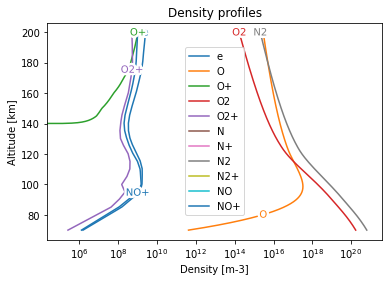

In [5]:
model.plot_density()

In [6]:
dt = 0.01
#con.enable()
#for i in range(2000):
#    model.update_timestep(dt)
#    #plot_snapshot(model)
#    #if model.time%1 == 0: setup_.datadump(model)
#    if model.iteration_step%1 == 0: 
#        setup_.datadump(model)
#    if model.iteration_step%1000 == 0:
#        print(model.time)
#    
    

In [7]:
model.time/60/60

0.0

In [8]:
"""
check charge conservation!!
any other important things?
"""

'\ncheck charge conservation!!\nany other important things?\n'

In [9]:
import pickle

def loadall(filename):
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break
                
data = list(loadall(log_directory + '/Simulation/log.p'))

data[0].all_species[3].density

array([1.71698197e+20, 1.69839209e+20, 1.67994923e+20, ...,
       1.72829527e+14, 1.71981904e+14, 1.71138737e+14])

In [10]:
time = np.array([i.time for i in data])
densities = np.array([[j.density for j in i.all_species] for i in data])

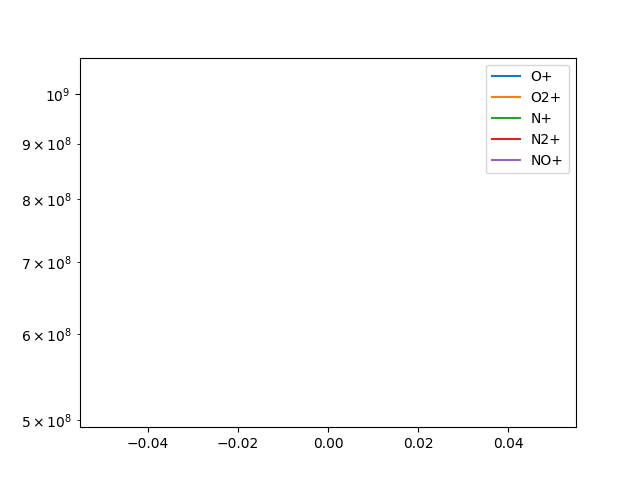

In [11]:
%matplotlib widget
plt.figure()
for c in data[0].ions:
    i = c.c_ID
    plt.plot(time, densities[:, i, -1], label=c.name)
plt.yscale('log')
plt.legend()

In [12]:
#do some testing with ion chemistry, eg only recombinative processes and see how it evovles
#why do i have problmes with charge neutrality for larger timesteps?
model.all_reactions[0].r_rate()

array([4.00000000e-13, 4.00000000e-13, 4.00000000e-13, ...,
       2.32215636e-13, 2.32134807e-13, 2.32054063e-13])

/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_96526/2968939675.py:13: RuntimeWarning: divide by zero encountered in true_divide
  decay_time[c.c_ID] = 1/(r.r_rate()*model.all_species[id_other_cinst].density)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_96526/2968939675.py:13: RuntimeWarning: divide by zero encountered in true_divide
  decay_time[c.c_ID] = 1/(r.r_rate()*model.all_species[id_other_cinst].density)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_96526/2968939675.py:13: RuntimeWarning: divide by zero encountered in true_divide
  decay_time[c.c_ID] = 1/(r.r_rate()*model.all_species[id_other_cinst].density)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_96526/2968939675.py:13: RuntimeWarning: divide by zero encountered in true_divide
  decay_time[c.c_ID] = 1/(r.r_rate()*model.all_species[id_other_cinst].density)
/var/folders/gg/y13kmxq903n_0k8qcq3bqf4r0000gp/T/ipykernel_96526/2968939675.py:13: RuntimeWarning: divide by zero en

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


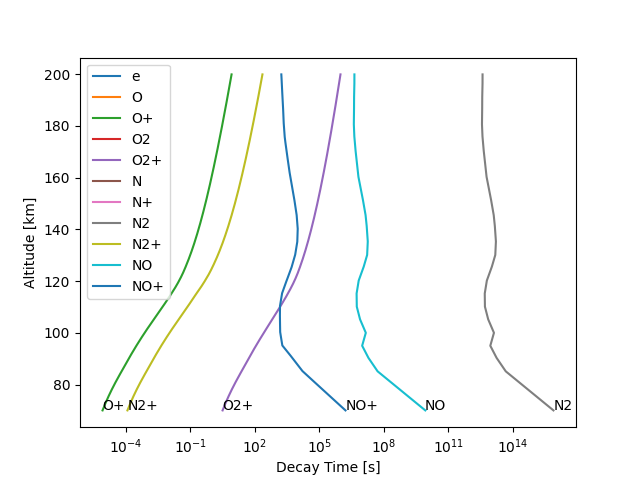

In [13]:
#calculate decay times
con.enable()
plt.figure()
eff_rr = np.zeros([len(model.all_species), len(z_model)])
for c in model.all_species:
    decay_time = np.zeros([len(model.all_species), len(z_model)])
    rr_species = np.zeros([len(model.all_species), len(z_model)])
    for r in model.all_reactions:
        if c.c_ID in r.educts_ID:
            #if con.print: print(r.r_stoch, '\n', c.name, r.educts[r.educts != c.name], '\n', c.c_ID, r.educts_ID[r.educts_ID != c.c_ID], '\n')
            [id_other_cinst] = r.educts_ID[r.educts_ID != c.c_ID]
            rr_species[c.c_ID] = r.r_rate()*model.all_species[id_other_cinst].density
            decay_time[c.c_ID] = 1/(r.r_rate()*model.all_species[id_other_cinst].density)
    plt.plot(np.sum(decay_time, axis = 0), z_model/1e3, label = c.name)
    plt.text(np.sum(decay_time, axis = 0)[1], z_model[1]/1e3, c.name)
    eff_rr[c.c_ID, :] = np.sum(rr_species, axis = 0)
    
filter_ = eff_rr[:, :] > 1 
sum_rows = np.sum(filter_, axis = 0) #number of "instantaneaous" DE per height bin

plt.xscale('log')
plt.xlabel('Decay Time [s]')
plt.ylabel('Altitude [km]')
plt.legend()

In [14]:
def fun(t, n, h):
    ode = np.zeros(n.shape)
    
    for c in model.all_species:
        i = c.c_ID
        loss_rr  = np.array(model.loss_table_rr[:, i, h])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, h])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr*n[loss_IDs], axis = 0) * n[i] + np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0)
    return ode


import time 

start = time.time()
model.prodTable()
model.lossTable()
for h in range(model.n_heights):
    n = np.array([c.density[h] for c in model.all_species])
    res = solve_ivp(fun, (0, 1), n, method='Radau',vectorized=False, args = [h])
    #for j, c in enumerate(model.all_species):
        #c.density[h] = res.y[j, -1]
print(time.time() - start)


13.93872880935669


In [15]:
res

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 131
     njev: 2
      nlu: 34
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.43152917e-13, 1.03746821e-11, 1.04689974e-10,
       1.04784289e-09, 1.04793721e-08, 1.04794664e-07, 1.04794758e-06,
       1.04794768e-05, 1.04794768e-04, 1.04794769e-03, 1.04794769e-02,
       4.94464939e-02, 1.29607917e-01, 2.60159689e-01, 4.34367735e-01,
       6.75568849e-01, 9.16769963e-01, 1.00000000e+00])
 t_events: None
        y: array([[2.54820002e+09, 2.54820002e+09, 2.54820002e+09, 2.54820002e+09,
        2.54820002e+09, 2.54820002e+09, 2.54820002e+09, 2.54820001e+09,
        2.54820001e+09, 2.54819994e+09, 2.54819925e+09, 2.54819227e+09,
        2.54816249e+09, 2.54809708e+09, 2.54798117e+09, 2.54781407e+09,
        2.54756847e+09, 2.54731335e+09, 2.54722388e+09],
       [2.94875068e+15, 2.94875068e+15, 2.94875068e+15, 2.94875068e+15,
        2.94875068e+15, 2.94875068e+

Text(0, 0.5, 'Density [m-3]')

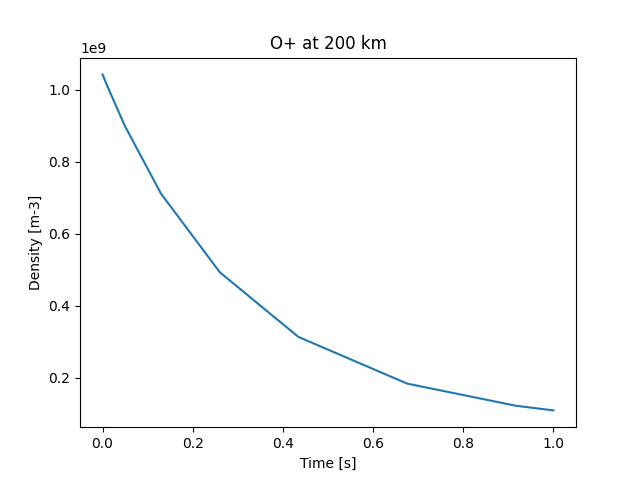

In [16]:
plt.figure()
plt.plot(res.t, res.y[2, :])
plt.title('O+ at 200 km')
plt.xlabel('Time [s]')
plt.ylabel('Density [m-3]')
#plt.yscale('log')

In [17]:
 res.y[0, :]

array([2.54820002e+09, 2.54820002e+09, 2.54820002e+09, 2.54820002e+09,
       2.54820002e+09, 2.54820002e+09, 2.54820002e+09, 2.54820001e+09,
       2.54820001e+09, 2.54819994e+09, 2.54819925e+09, 2.54819227e+09,
       2.54816249e+09, 2.54809708e+09, 2.54798117e+09, 2.54781407e+09,
       2.54756847e+09, 2.54731335e+09, 2.54722388e+09])

In [ ]:
#rewrite!!!
def fun(t, n):
    n = n.reshape([-1, model.n_heights])
    ode = np.zeros(n.shape)
    
    for i, c in enumerate(model.all_species):
        loss_rr  = np.array(model.loss_table_rr[:, i, :])
        loss_IDs = np.array(model.loss_table_ind[:, i], dtype = int)
        
        prod_rr   = np.array(model.prod_table_rr[:, i, :])
        prod_IDs1 = np.array(model.prod_table_ind[:, i, 0], dtype = int)
        prod_IDs2 = np.array(model.prod_table_ind[:, i, 1], dtype = int)
        
        #loss, prod:
        ode[i] = -np.sum(loss_rr*n[loss_IDs], axis = 0) * n[i] \
                    + np.sum(prod_rr * n[prod_IDs1] * n[prod_IDs2], axis = 0)
    return ode.flat

import time
start = time.time()
n = np.array([c.density for c in model.all_species])
model.prodTable()
model.lossTable()
#fun(1, n)
print(start)
res2 = solve_ivp(fun, (0, 0.01), n.flat, method='Radau',vectorized=False)
print(time.time() - start)


1665661967.5260391


In [ ]:
res2

In [ ]:
plt.figure()
plt.plot(res2.t, res2.y.reshape([11, model.n_heights, len(res2.t)])[2, -1, :], 'o')
plt.plot(res.t, res.y[2, :], 'x')
plt.title('O+ at 200 km')
plt.xlabel('Time [s]')
plt.ylabel('Density [m-3]')

In [ ]:
       

#for i in set(sum_rows):
#    #select relevant data according to set
#    z_model[sum_rows == i]
#    eff_rr.T[sum_rows == i]
#    #single out fast decays, solve seperately
#    
#    #solve ODE
#    
    
    
    
if con.print: print(sum_rows)
if con.print: print(filter_)
eff_rr[filter_] = 0

In [ ]:
#to do: define Tr, Te, Tn before each iteration, do not pass temperature as function to reaction rate calculator

In [ ]:
a = np.array([1, 2, 3])
#a = np.array([a, a, a])

In [ ]:
type(a)

In [ ]:
eff_rr

In [ ]:
densities

In [ ]:
n.shape

In [ ]:
a = np.array([1, 2, 3])

In [ ]:
a*3

In [ ]:
len(a)